# Do Actual Fit

In [1]:
%matplotlib inline
import numpy as np
from numpy import loadtxt
from lmfit.models import ExponentialModel, ConstantModel
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

#Import and data and make histogram
data_208=loadtxt('Data/Corina_Ian_Thres208mVIntervals2015_11_05-13-33.txt'\
                 ,unpack=True)[1]
counts_208,bin_edges_208=np.histogram(data_208[3:],20)
bin_centres_208 = (bin_edges_208[:-1] + bin_edges_208[1:])/2.
err_208 = np.sqrt(counts_208)

/usr/local/lib/python3.4/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
#Make Model and Do Fit

exp_mod = ExponentialModel(prefix="exp_")
cnst_mod = ConstantModel(prefix="cnst_")

#Initial Guess
pars = exp_mod.make_params(exp_decay=2000,exp_amp=1400)
pars += cnst_mod.guess(counts_208,x=bin_centres_208,c=600)

#Do fit
mod = exp_mod+cnst_mod
out = mod.fit(counts_208, pars, x=bin_centres_208,weights=1/err_208)
print(out.fit_report())

[[Model]]
    (Model(exponential, prefix='exp_') + Model(constant, prefix='cnst_'))
[[Fit Statistics]]
    # function evals   = 102
    # data points      = 20
    # variables        = 3
    chi-square         = 16.570
    reduced chi-square = 0.975
[[Variables]]
    exp_amplitude:   1560.52410 +/- 45.71716 (2.93%) (init= 1)
    exp_decay:       2245.67801 +/- 73.15375 (3.26%) (init= 2000)
    cnst_c:          165.162704 +/- 4.120412 (2.49%) (init= 600)
[[Correlations]] (unreported correlations are <  0.100)
    C(exp_amplitude, exp_decay)  = -0.710 
    C(exp_decay, cnst_c)         = -0.518 
    C(exp_amplitude, cnst_c)     =  0.159 



In [3]:
decay_param = out.params['exp_decay']
decay_param.stderr
print(type(err_208))

<class 'numpy.ndarray'>


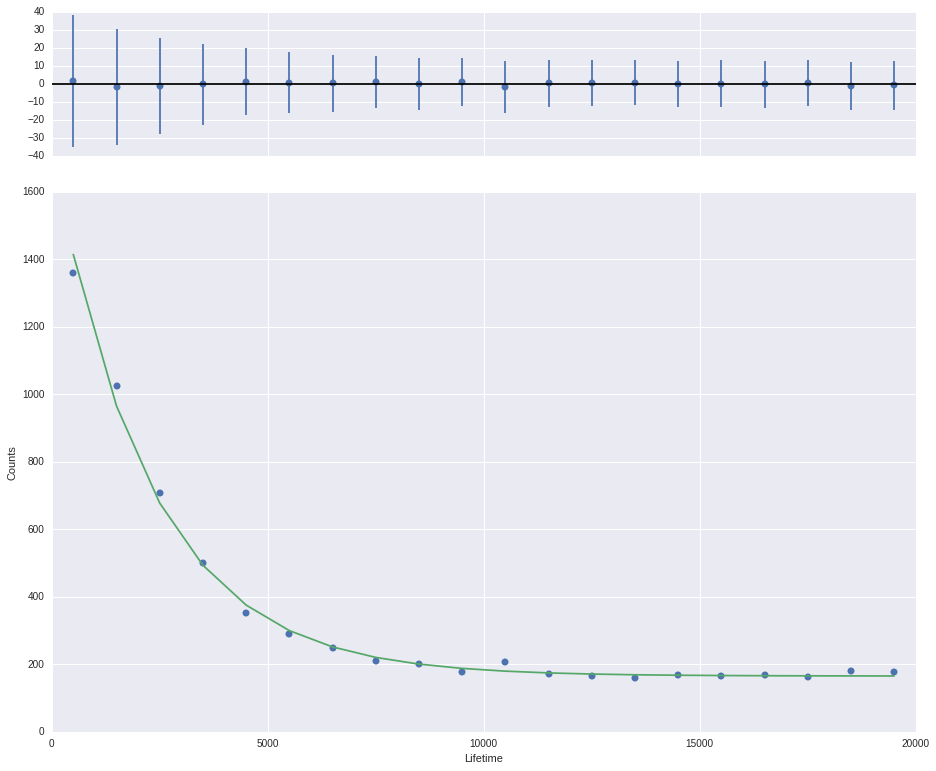

In [4]:
#Make plot with residual plot
#sns.set_style('darkgrid')
#Make A plot
fig1 = plt.figure(1,figsize=(15,10))
frame1=fig1.add_axes((.1,.1,.8,.75))
plt.plot(bin_centres_208, counts_208, 'o')
plt.plot(bin_centres_208, out.best_fit, '-')
plt.xlabel('Lifetime')
plt.ylabel('Counts')

frame2=fig1.add_axes((.1,.9,.8,.2))

plt.errorbar(bin_centres_208,out.residual,fmt='o',yerr=err_208)
plt.axhline(color='black')
frame2.set_xticklabels([])

plt.show()

# Find ChiSq vs Binning
This cell is pretty messy. Doesn't need to. Still holds some experimentation. fit_plot isn't used yet but when finished should reduce redundancy by eliminating need to type plt.plot... over and over.

In [5]:
def doFit(bins=50):
    counts_208,bin_edges_208=np.histogram(data_208[3:],bins)
    bin_centres_208 = (bin_edges_208[:-1] + bin_edges_208[1:])/2.

    while (counts_208[0]-counts_208[1]<0):
        bin_centres_208=bin_centres_208[1:]
        counts_208=counts_208[1:]
    if bins<35:
        bin_centres_208=bin_centres_208[1:]
        counts_208=counts_208[1:]
    err_208 = np.sqrt(counts_208)
    mod = ExponentialModel()+ConstantModel()


    exp_mod = ExponentialModel(prefix="exp_")
    cnst_mod = ConstantModel(prefix="cnst_")

    pars = exp_mod.make_params(exp_decay=2000,exp_amp=1400)
    pars += cnst_mod.guess(counts_208,x=bin_centres_208,c=counts_208[len(counts_208)-1])

    mod = exp_mod+cnst_mod

    out = mod.fit(counts_208, pars, x=bin_centres_208,weights=1/err_208)
    return (bin_centres_208,counts_208),out
redChi=[]
maxBins=200
minBins=10

def makePlot(pp,minB,maxB,interactive=False):
    from bokeh import mpl
    from bokeh.embed import components
    from bokeh.plotting import output_file, show
    redChi=[]
    for i in range(minB,maxB):
        redChi.append(doFit(i)[1].redchi)
    plt.rc('text', usetex=True)
    plt.ylabel(r'$\tilde{\chi}^2$')
    plt.xlabel('Number of Bins')
    plt.plot(range(minB,maxB),redChi,'ko')
    plt.savefig(pp, format='pdf')
    if interactive:
        #make interactive plot
        plt.ylabel('Reduced ChiSq') # bokeh can't handle latex yet
        output_file("sinerror.html")
        show(mpl.to_bokeh())
        #print(components(mpl.to_bokeh())[0])
        #return mpl.to_bokeh()
def fit_plot(bins=50,plt_init=False):
    data,out=doFit(bins)
    sns.set_style('darkgrid')
    #Make A plot
    fig1 = plt.figure(1,figsize=(15,10))
    frame1=fig1.add_axes((.1,.1,.8,.75))
    plt.errorbar(data[0], data[1], fmt='o',yerr=np.sqrt(data[1]))
    plt.plot(data[0], out.best_fit, '-')
    if plt_init:
        plt.plot(data[0],out.init_fit,'--')
    plt.xlabel('Lifetime')
    plt.ylabel('Counts')

    frame2=fig1.add_axes((.1,.9,.8,.2))

    plt.errorbar(data[0],out.residual,fmt='o',yerr=np.sqrt(data[1]))
    plt.axhline(color='black')
    frame2.set_xticklabels([])
    plt.show()

def makePlotBestVal(pp,minB,maxB,interactive=False):
    from bokeh import mpl
    from bokeh.embed import components
    from bokeh.plotting import output_file, show
    tau=[]
    errs=[]
    for i in range(minB,maxB):
        out = doFit(i)[1]
        tau.append(out.best_values['exp_decay'])
        errs.append(out.params['exp_decay'].stderr)
    plt.figure(figsize=(20,20))
    # plt.rc('text', usetex=True)
    # plt.ylabel(r'$\tau$')
    plt.ylabel('Tau')
    plt.xlabel('Number of Bins')
    plt.errorbar(range(minB,maxB),tau,fmt='o',yerr=errs)
    plt.xlim(25,210)
    plt.ylim(1900,2150)
    plt.grid(True)
    plt.show()
    plt.savefig(pp, format='pdf')
    if interactive:
        #make interactive plot
        plt.ylabel('Tau') # bokeh can't handle latex yet
        output_file("sinerror.html")
        show(mpl.to_bokeh())
        #print(components(mpl.to_bokeh())[0])
        #return mpl.to_bokeh()

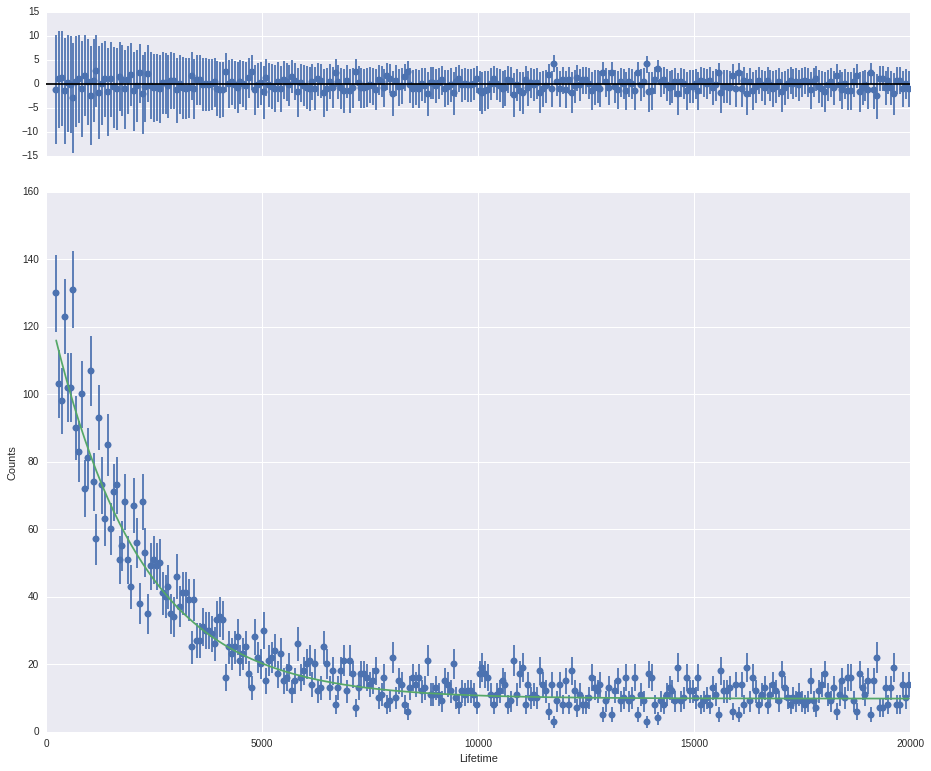

In [6]:
fit_plot(300)

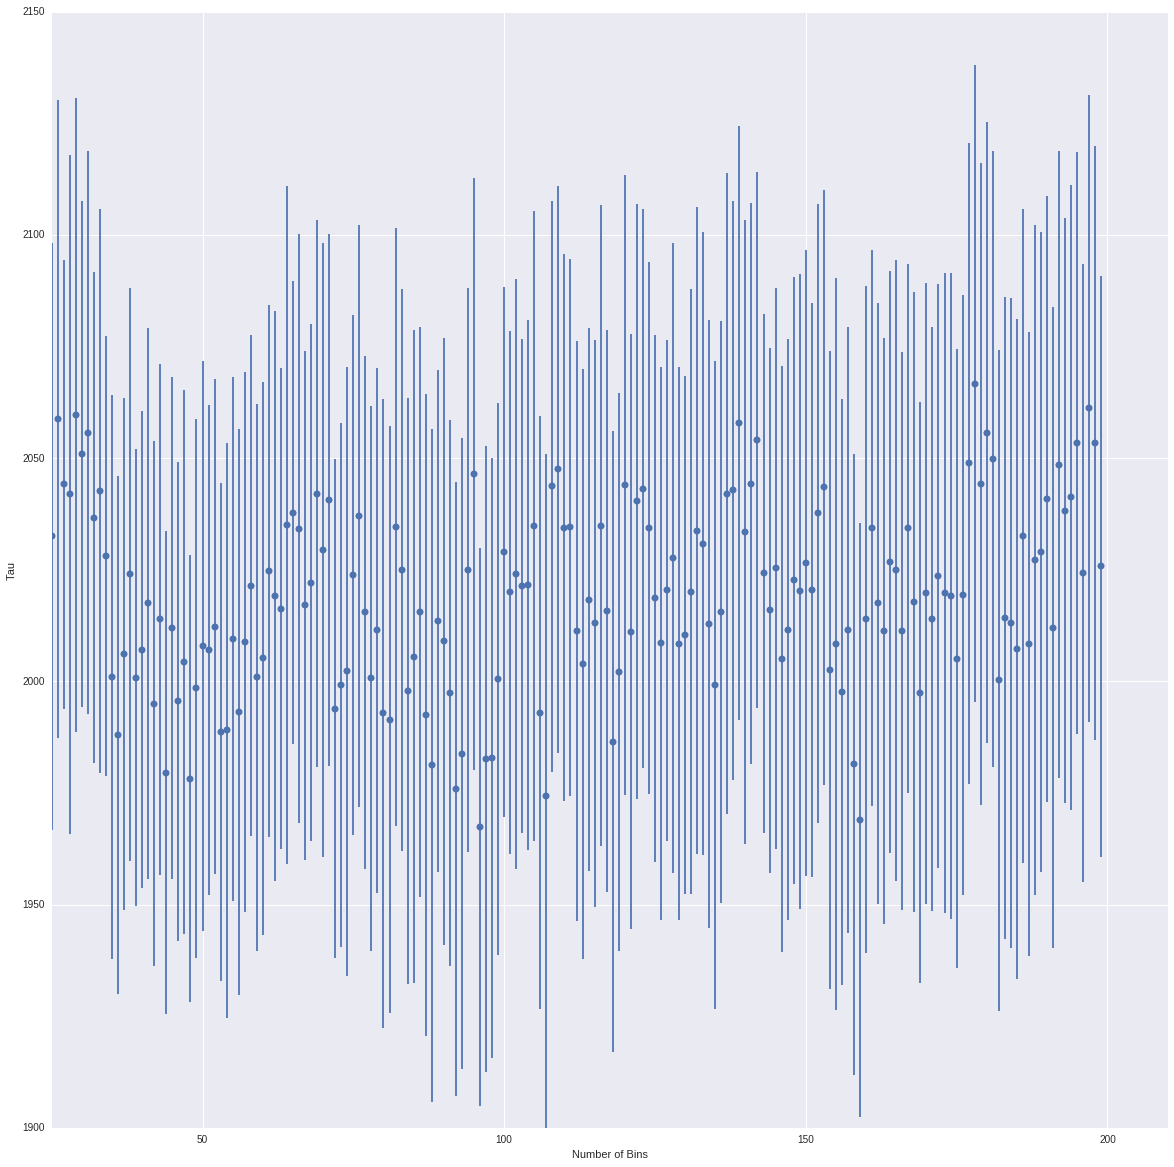

In [7]:
pp = PdfPages('bestVals.pdf')
makePlotBestVal(pp,15,200,False)
pp.close()

In [8]:
#Create Nice output pdf. makePlot also generates interactive plot
pp = PdfPages('multipage.pdf')
makePlot(pp,10,200,True)
pp.close()

# Rate Stuff

In [9]:
def red(time):
    '''
    This should eliminate the issue of the weird time jump about 2/3 of way through collection also that t=0 if 0 counts
    '''
    return np.arange(0,len(time))
def hours(secs,counts):
    import numpy
    hours=numpy.arange(0,secs[len(secs)-1]//3600+1)
    binned_counts=[0]*len(hours)
    for i in range(0,len(secs)):
        index=i//3600
        binned_counts[index]+=counts[i]
    return hours,binned_counts

In [10]:
'''
Load data and cut out end where every value is 0 for several days. Also cut the good data short as the last hour is not a complete hour

'''
time_400, rate_400 = np.loadtxt('Data/Corina_Ian_Thres400mVRate2015_11_10-13-24.txt', unpack=True)

last_hour_index =424800
time_400=time_400[0:last_hour_index]
rate_400=rate_400[0:last_hour_index]
hour_time,binned_counts=hours(red(time_400),rate_400)

[[Model]]
    Model(sin)
[[Fit Statistics]]
    # function evals   = 39
    # data points      = 118
    # variables        = 3
    chi-square         = 236.923
    reduced chi-square = 2.060
[[Variables]]
    amp:     39.6430512 +/- 25.83521 (65.17%) (init= 5)
    omega:   0.2617994 (fixed)
    shift:   8.14717089 +/- 0.640707 (7.86%) (init= 0)
    y0:      18780.9008 +/- 18.11357 (0.10%) (init= 18800)
[[Correlations]] (unreported correlations are <  0.100)



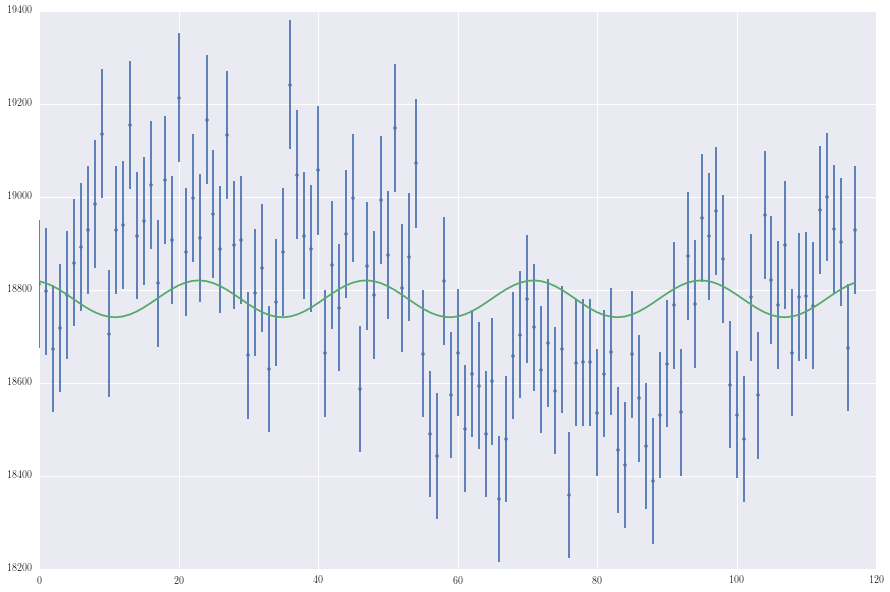

In [11]:
def sin(x, amp,omega,shift,y0):
    """ model decaying sine wave, subtract data"""
    #amp = params['amp'].value
    #shift = params['shift'].value
    #omega = params['omega'].value
    
    return amp * np.sin(x * omega + shift)+y0
from lmfit import Model
gmod = Model(sin)
params = gmod.make_params(amp=5, omega=.26,shift=0,y0=18800)
params.add('omega',value=2*np.pi/24,vary=False)
#params.pretty_print()
result = gmod.fit(binned_counts,params,x=hour_time,weights=1/np.sqrt(binned_counts))


print(result.fit_report())
x=hour_time
y=binned_counts
plt.figure(figsize=(15,10))
plt.errorbar(x, y,fmt='.',yerr=np.sqrt(y))
#plt.plot(x, result.init_fit, 'k--')
plt.plot(x, result.best_fit, '-')
plt.show()

In [12]:
time_jason, rate_jason = np.loadtxt('Data/JasonRate2014_11_11-13-21.txt', unpack=True)
last_hour_index=421200
time_jason=time_jason[0:last_hour_index]
rate_jason=rate_jason[0:last_hour_index]
hour_time_jason,binned_counts_jason=hours(red(time_jason),rate_jason)

[[Model]]
    Model(sin)
[[Fit Statistics]]
    # function evals   = 23
    # data points      = 117
    # variables        = 3
    chi-square         = 329.234
    reduced chi-square = 2.888
[[Variables]]
    amp:    -83.7339505 +/- 45.21585 (54.00%) (init= 5)
    omega:   0.2617994 (fixed)
    shift:  -0.00483965 +/- 0.546270 (11287.40%) (init= 0)
    y0:      41850.1156 +/- 32.16176 (0.08%) (init= 18800)
[[Correlations]] (unreported correlations are <  0.100)



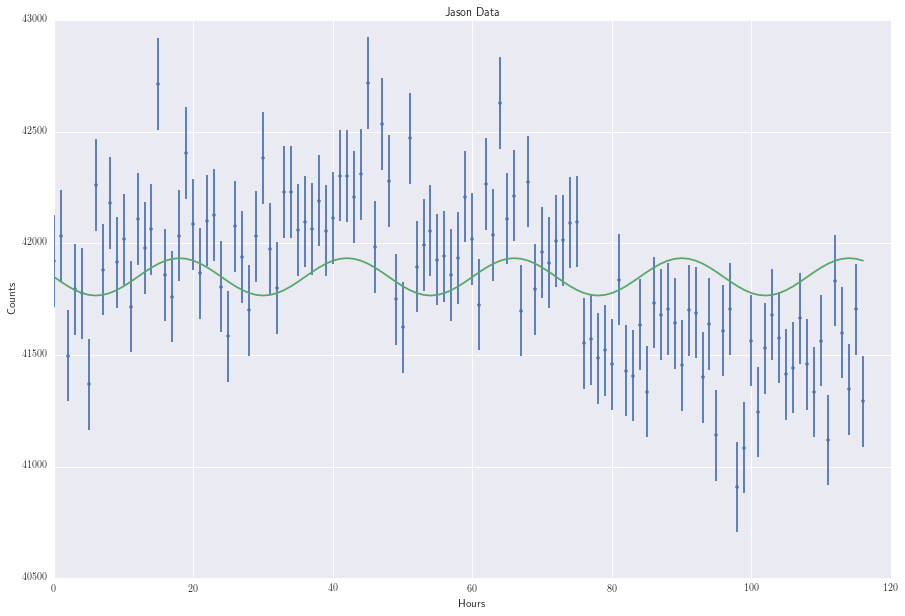

In [13]:
result = gmod.fit(binned_counts_jason,params,x=hour_time_jason,weights=1/np.sqrt(binned_counts_jason))

print(result.fit_report())
x=hour_time_jason
y=binned_counts_jason
plt.figure(figsize=(15,10))
plt.errorbar(x, y,fmt='.',yerr=np.sqrt(y))
#plt.plot(x, result.init_fit, 'k--')
plt.plot(x, result.best_fit, '-')
plt.title('Jason Data')
plt.xlabel('Hours')
plt.ylabel('Counts')
plt.show()